<img align="right" src="https://raw.githubusercontent.com/GT4SD/gt4sd-core/main/docs/_static/gt4sd_logo.png" alt="logo" width="100" height="100"/>

# Demo: The Generative Toolkit for Scientific Discovery


In [1]:
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
from rdkit import Chem
from gt4sd_common.properties import PropertyPredictorRegistry
from rdkit.Chem.Scaffolds.MurckoScaffold import GetScaffoldForMol
import pandas as pd
import mols2grid

INFO:toxsmi.utils.wrappers:Class weights are (1, 1).
INFO:toxsmi.utils.wrappers:Class weights are (1, 1).
INFO:toxsmi.utils.wrappers:Class weights (1, 1) are ignored.
INFO:toxsmi.utils.wrappers:Class weights (1, 1) are ignored.
INFO:toxsmi.utils.wrappers:Class weights (1, 1) are ignored.
INFO:toxsmi.utils.wrappers:Class weights (1, 1) are ignored.


### Let us have a look at a novel, AI-generated DDR1 kinase inhibitor

The following molecule is one of the first AI-generated molecules in drug discovery. It was demonstrated to have pharmacokinetic activity in mice. 
The molecule was proposed by the GENTRL algorithm, a variational autoencoder that was optimized with tensorial reinforcement learning (Zhavoronkov et al., 2019; _Nature Biotech_).

Throughout the tutorial, we will call the molecule 
- **gentrl_ddr1**

since it was developed to inhibit protein kinase DDR1.



For details on this molecule and its relation to already marketed drugs (e.g., Ponatinib), please see:

```txt
Zhavoronkov, A., Ivanenkov, Y. A., Aliper, A., Veselov, M. S., Aladinskiy, V. A., Aladinskaya, A. V., ... & Aspuru-Guzik, A. (2019). Deep learning enables rapid identification of potent DDR1 kinase inhibitors. Nature biotechnology, 37(9), 1038-1040.

Walters, W. P., & Murcko, M. (2020). Assessing the impact of generative AI on medicinal chemistry. Nature biotechnology, 38(2), 143-145.
```

In [2]:
gentrl_ddr1_smi = "C12C=CC=NN1C(C#CC1=C(C)C=CC3C(NC4=CC(C(F)(F)F)=CC=C4)=NOC1=3)=CN=2"
gentrl_ddr1_mol = Chem.MolFromSmiles(gentrl_ddr1_smi)
sol = PropertyPredictorRegistry.get_property_predictor("esol")
gentrl_ddr1_sol = sol(gentrl_ddr1_mol)
gentrl_ddr1_scaff = GetScaffoldForMol(gentrl_ddr1_mol)
gentrl_ddr1_scaff_smi = Chem.MolToSmiles(GetScaffoldForMol(gentrl_ddr1_mol))


mols2grid.display(
    pd.DataFrame(
        {
            "SMILES": [gentrl_ddr1_smi],
            "Name": ["gentrl_ddr1"],
            "Solubility": [gentrl_ddr1_sol],
            "Solubility Val": [f"Solubility = {x:.3f}" for x in [gentrl_ddr1_sol]],
        }
    ),
    size=(800, 250),
    tooltip=["SMILES", "Name", "Solubility"],
    subset=["Name", "img", "Solubility Val"],
)

MolGridWidget()

# GT4SD Discovery usecase
## Find a similar molecule with improved water solubility

The paper of Zhavoronkov et al. (2019; _Nature Biotech_) reports that the shown molecule binds strongly to DDR1 (10nM) in _in-vitro_ experiments and showed good efficacy in mice. 

### **Goal:** 
For the sake of this tutorial, consider the hypothetical scenario that the drug was taken to the next experimental stage, given to primates and not found effective. Trying to understand the problem, the researchers find that their drug does not dissolve in water sufficiently well method and thus cannot be delievered to the tumor. In order to not have to discard the drug entirely and restart their research from scratch, the researchers decide to search for a molecule that is **similar** to **gentrl_ddr1** but has a higher **solubility** than it.

Finding such a molecule is the goal of this tutorial. 

- We measure **similarity** with a structural similarity measure, the Tanimoto similarity of Morgan fingerprints (ECFP; *Rogers and Hahn, 2012*).
- We measure **solubility** using the method called **ESOL** proposed by Delaney, J. S. (2004; _Journal of chemical information and computer sciences_)
 


NOTE: This is obviously a highly artificial & simplistic discovery task but it gives us the opportunity to showcase many of the generative algorithms implemented in the GT4SD.



Import the algorithms and helper functions:

In [3]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import logging
import sys

logging.disable(sys.maxsize)
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
from paccmann_chemistry.utils import disable_rdkit_logging
from gt4sd_inference_moler.algorithms.generation.moler import (
    MoLeR,
    MoLeRDefaultGenerator,
)
from gt4sd_inference_torch_drug.algorithms.generation.torchdrug import (
    TorchDrugGenerator,
    TorchDrugGCPN,
    TorchDrugGraphAF,
)
from gt4sd_inference_paccmann.algorithms.generation.paccmann_vae import (
    PaccMannVAE,
    PaccMannVAEGenerator,
)

from gt4sd_inference_guacamol.algorithms.conditional_generation.guacamol import (
    GuacaMolGenerator,
)
from gt4sd_inference_guacamol.algorithms.conditional_generation.guacamol import (
    VaeGenerator,
    AaeGenerator,
    OrganGenerator,
)
from gt4sd_inference_regression.algorithms.conditional_generation.regression_transformer import (
    RegressionTransformer,
    RegressionTransformerMolecules,
)
from tqdm import tqdm
import pandas as pd
from rdkit.DataStructs import FingerprintSimilarity
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

clang: error: unsupported option '-fopenmp'
clang: error: unsupported option '-fopenmp'


## First attempt: 
#### Using unconditional molecular generative models that draw "random" samples from a learned chemical space

In [20]:
# Inititalize algorithms
moler_config = MoLeRDefaultGenerator()
moler_alg = MoLeR(configuration=moler_config)

organ_config = OrganGenerator()
organ_alg = GuacaMolGenerator(configuration=organ_config, target={})

vae_config = VaeGenerator()
vae_alg = GuacaMolGenerator(configuration=vae_config, target={})

aae_config = AaeGenerator()
aae_alg = GuacaMolGenerator(configuration=aae_config, target={})

gcpn_config = TorchDrugGCPN(algorithm_version="zinc250k_v0")
gcpn_alg = TorchDrugGenerator(configuration=gcpn_config)

graphaf_config = TorchDrugGraphAF(algorithm_version="zinc250k_v0")
graphaf_alg = TorchDrugGenerator(configuration=graphaf_config)

paccmannvae_configuration = PaccMannVAEGenerator()
paccmannvae_alg = PaccMannVAE(configuration=paccmannvae_configuration)

unconditional_algorithms = [
    moler_alg,
    organ_alg,
    vae_alg,
    aae_alg,
    gcpn_alg,
    graphaf_alg,
    paccmannvae_alg,
]
unconditional_names = ["MoLeR", "ORGAN", "VAE", "AAE", "GCPN", "GraphAF", "PaccMannVAE"]
# unconditional_names = [   "AAE"]
# unconditional_algorithms = [ aae_alg]

# To compute similarity to our molecule
gentrl_ddr1_fp = GetMorganFingerprintAsBitVect(gentrl_ddr1_mol, radius=2)
get_tani = lambda x: FingerprintSimilarity(
    gentrl_ddr1_fp, GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x), radius=2)
)

using bucket=gt4sd-cos-algorithms-artifacts path=/Users/phildowney/.gt4sd/algorithms/generation/MoLeR/MoLeRDefaultGenerator/v0 prefix=generation/MoLeR/MoLeRDefaultGenerator/v0
using bucket=gt4sd-cos-hub-algorithms-artifacts path=/Users/phildowney/.gt4sd/algorithms/generation/MoLeR/MoLeRDefaultGenerator/v0 prefix=generation/MoLeR/MoLeRDefaultGenerator/v0
using bucket=gt4sd-cos-algorithms-artifacts path=/Users/phildowney/.gt4sd/algorithms/conditional_generation/MosesGenerator/OrganGenerator/v0 prefix=conditional_generation/MosesGenerator/OrganGenerator/v0
using bucket=gt4sd-cos-hub-algorithms-artifacts path=/Users/phildowney/.gt4sd/algorithms/conditional_generation/MosesGenerator/OrganGenerator/v0 prefix=conditional_generation/MosesGenerator/OrganGenerator/v0
using bucket=gt4sd-cos-algorithms-artifacts path=/Users/phildowney/.gt4sd/algorithms/conditional_generation/MosesGenerator/VaeGenerator/v0 prefix=conditional_generation/MosesGenerator/VaeGenerator/v0
using bucket=gt4sd-cos-hub-algor

In [ ]:
# Sample from the models (this will take a while)

num_samples = 100  # number of molecules sampled per model
mol_df = pd.DataFrame()
batch_size = 32

for model, name in tqdm(
    zip(unconditional_algorithms, unconditional_names),
    total=len(unconditional_algorithms),
    desc="Processing algorithm number:",
):
    smiles = []
    while len(smiles) < num_samples:
        smis = list(model.sample(batch_size))
        smiles.extend([s for s in smis if Chem.MolFromSmiles(s) and s not in smiles])
    mol_df = pd.concat(
        [
            mol_df,
            pd.DataFrame(
                {
                    "smiles": smiles,
                    "algorithm": [name] * len(smiles),
                    "solubility": list(
                        map(lambda x: sol(Chem.MolFromSmiles(x)), smiles)
                    ),
                    "similarity": list(map(get_tani, smiles)),
                }
            ),
        ],
        axis=0,
    )
mol_df = mol_df.reset_index()

Processing algorithm number::   0%|                                                                                             | 0/7 [00:00<?, ?it/s]

Loading a trained model from: /Users/phildowney/.gt4sd/algorithms/generation/MoLeR/MoLeRDefaultGenerator/v0/GNN_Edge_MLP_MoLeR__2022-02-24_07-16-23_best.pkl


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


Loading a trained model from: /Users/phildowney/.gt4sd/algorithms/generation/MoLeR/MoLeRDefaultGenerator/v0/GNN_Edge_MLP_MoLeR__2022-02-24_07-16-23_best.pkl


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


Loading a trained model from: /Users/phildowney/.gt4sd/algorithms/generation/MoLeR/MoLeRDefaultGenerator/v0/GNN_Edge_MLP_MoLeR__2022-02-24_07-16-23_best.pkl


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


Loading a trained model from: /Users/phildowney/.gt4sd/algorithms/generation/MoLeR/MoLeRDefaultGenerator/v0/GNN_Edge_MLP_MoLeR__2022-02-24_07-16-23_best.pkl


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Generating samples: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 72.22it/s]
[13:08:12] SMILES Parse Error: unclosed ring for input: 'Cn1cc(-c2ccc(N3CCC(n4c(=O)[nH]c5ncccc55)CC4CNCC43)cc2)cn1'
[13:08:12] Can't kekulize mol.  Unkekulized atoms: 12 13 14 16 20 21 23

Generating samples: 100%|█████████████████████████████████████████████████████

Text(0.5, 1.0, 'Similarity of generated molecules (n=100 per model)')

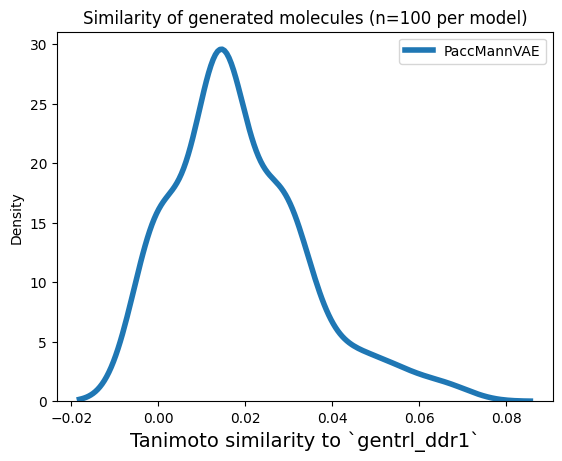

In [6]:
# Plot Tanimoto similarity per model
for model in mol_df.algorithm.unique():
    tdf = mol_df[mol_df.algorithm == model]
    sns.distplot(tdf["similarity"], label=model, hist=False, kde_kws={"linewidth": 4})

plt.legend()
plt.xlabel("Tanimoto similarity to `gentrl_ddr1`", size=14)
plt.title(f"Similarity of generated molecules (n={num_samples} per model)")

Text(0.5, 1.0, 'Solubility of generated molecules (n=100 per model)')

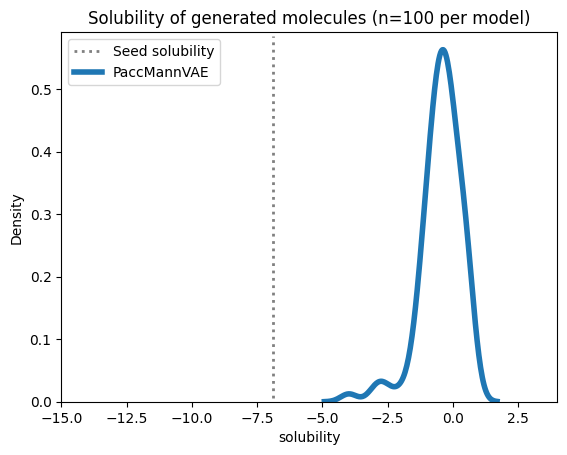

In [7]:
# Plot solubility per model

# Mark in dashed gray the solubility of the starting molecule
plt.axvline(
    x=gentrl_ddr1_sol,
    ymin=0.01,
    ymax=0.99,
    color="gray",
    label="Seed solubility",
    ls=":",
    lw=2,
)

for model in mol_df.algorithm.unique():
    tdf = mol_df[mol_df.algorithm == model]
    sns.distplot(tdf["solubility"], label=model, hist=False, kde_kws={"linewidth": 4})
plt.xlim([-15, 4])
plt.legend()
plt.title(f"Solubility of generated molecules (n={num_samples} per model)")

Text(51.00189583333332, 0.5, 'Tanimoto similarity')

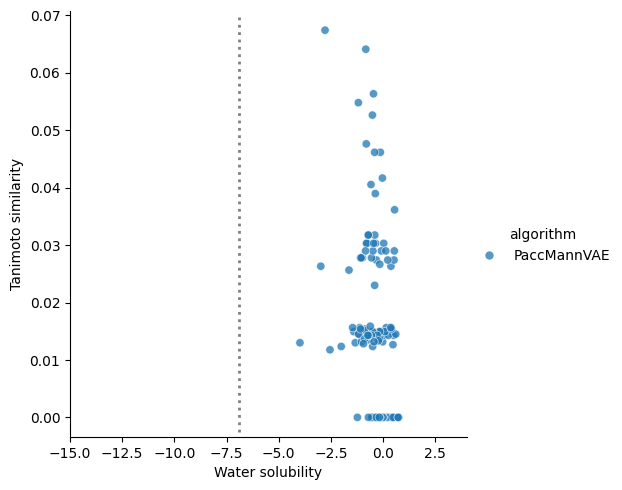

In [8]:
sns.relplot(data=mol_df, x="solubility", y="similarity", hue="algorithm", alpha=0.75)
plt.axvline(
    x=gentrl_ddr1_sol,
    ymin=0.01,
    ymax=0.99,
    color="gray",
    label="Seed solubility",
    ls=":",
    lw=2,
)
plt.xlim([-15, 4])
plt.xlabel("Water solubility")
plt.ylabel("Tanimoto similarity")

####  We can see that the GCPN, PaccMannVAE and GraphAF model generates molecules with the highest solubility scores. Moreover, the molecules generated by the AAE have the highest similarity to **gentrl_ddr1* compared to the molecules of the other models. 

#### Let us have a look at the best molecule per model

In [ ]:
best_mols = pd.concat(
    [
        mol_df[(mol_df.algorithm == model) & (mol_df.solubility > gentrl_ddr1_sol)]
        .sort_values(by="similarity", ascending=False)
        .head(1)
        for model in mol_df.algorithm.unique()
    ]
).sort_values(by="similarity", ascending=False)
best_mols["text"] = best_mols.apply(
    lambda x: f"Tanimoto={x['similarity']:.2f} (Solubility={x['solubility']:.2f})",
    axis=1,
)
mols2grid.display(
    best_mols,
    smiles_col="smiles",
    n_cols=len(best_mols) // 2,
    size=(300, 200),
    tooltip=["smiles", "algorithm", "solubility", "similarity"],
    subset=["algorithm", "img", "text"],
)

#### While the molecule from MoLeR indeed shares several rings with the seed molecule, a Tanimoto similarity of 0.21 cannot be considered similar enough. Therefore, we should try more controllable generative models.

## Second attempt: 
#### Using conditional molecular generative models that sample from a structure-constrained or property-driven learned chemical space

In [ ]:
# Conditional approaches
from gt4sd_inference_reinvent.algorithms.conditional_generation.reinvent import (
    Reinvent,
    ReinventGenerator,
)

# Inititalize algorithms

reinvent_config = ReinventGenerator()
reinvent_alg = Reinvent(configuration=reinvent_config, target=gentrl_ddr1_smi)


moler_config = MoLeRDefaultGenerator(scaffolds=gentrl_ddr1_smi)
moler_alg = MoLeR(configuration=moler_config)

moler_config_scaff = MoLeRDefaultGenerator(scaffolds=gentrl_ddr1_scaff_smi)
moler_alg_scaff = MoLeR(configuration=moler_config_scaff)

conditional_algorithms = [reinvent_alg, moler_alg, moler_alg_scaff]
conditional_names = ["REINVENT", "MoLeR", "MoLeR Scaff."]

to_mask = [0.2, 0.1]
for mask in to_mask:
    rt_config = RegressionTransformerMolecules(
        algorithm_version="solubility",
        search="sample",
        temperature=1.5,
        tolerance=60,
        sampling_wrapper={"fraction_to_mask": mask, "property_goal": {"<esol>": 0.234}},
    )
    rt_alg = RegressionTransformer(configuration=rt_config, target=gentrl_ddr1_smi)
    conditional_algorithms.append(rt_alg)
    conditional_names.append(f"RegressionTransformer ({mask})")

In [ ]:
# Sample from the models (this will take a while)
disable_rdkit_logging()
cg_mol_df = pd.DataFrame()
batch_size = 32
num_samples = 100


for model, name in tqdm(
    zip(conditional_algorithms, conditional_names),
    total=len(conditional_names),
    desc="Processing algorithm number:",
):
    smiles = []
    while len(smiles) < num_samples:
        smis = list(model.sample(batch_size))
        if "Regression" in name:
            smis = list(zip(*smis))[0]
        smiles.extend([s for s in smis if Chem.MolFromSmiles(s) and s not in smiles])
    cg_mol_df = pd.concat(
        [
            cg_mol_df,
            pd.DataFrame(
                {
                    "smiles": smiles,
                    "algorithm": [name] * len(smiles),
                    "solubility": list(
                        map(lambda x: sol(Chem.MolFromSmiles(x)), smiles)
                    ),
                    "similarity": list(map(get_tani, smiles)),
                }
            ),
        ],
        axis=0,
    )

# Remove re-generations of original molecule and add seed
cg_mol_df = cg_mol_df.reset_index()
cg_mol_df = cg_mol_df[cg_mol_df.similarity < 1]
cg_mol_df

In [ ]:
# Plot again the Tanimoto similarity per model
for model in cg_mol_df.algorithm.unique():
    tdf = cg_mol_df[cg_mol_df.algorithm == model]
    sns.distplot(tdf["similarity"], label=model, hist=False, kde_kws={"linewidth": 4})

plt.legend()
plt.xlabel("Tanimoto similarity to `gentrl_ddr1`", size=14)
plt.title(f"Similarity of generated molecules (n={num_samples} per model)")

### While the Reinvent molecules are generally not similar to **gentrl_ddr1**, the 2 MoLeR and the 2 RT models generated plenty of molecules with reasonable similarity to the seed. Overall, the MoLeR molecules had the highest average similarity. But how about their solubility?

In [ ]:
# Plot solubility per model
plt.axvline(
    x=gentrl_ddr1_sol,
    ymin=0.01,
    ymax=0.99,
    color="gray",
    label="Seed solubility",
    ls=":",
    lw=2,
)
for model in cg_mol_df.algorithm.unique():
    tdf = cg_mol_df[cg_mol_df.algorithm == model]
    sns.distplot(tdf["solubility"], label=model, hist=False, kde_kws={"linewidth": 4})

plt.legend()
plt.title(f"Solubility of generated molecules (n={num_samples} per model)")

### Here we can see that the molecules from the RegressionTransformer had the highest solubility scores. 
### The MoLeR molecules mostly had solubility values slightly below to the seed molecule. 
### Overall, these molecules are already much more similar to **gentrl_ddr1** than the ones from the unconditional models.
## Now, let's have a look which model and molecules fullfil both constraints (high similarity to the seed and an improved solubility)

In [ ]:
import matplotlib.cm as cm

num_steps = 200

fig, ax = plt.subplots(figsize=(8, 6))

# Green shade for desired solubility area
steps = np.linspace(gentrl_ddr1_sol, -3, num_steps)
for i in range(num_steps - 1):
    color = cm.Greens(min(i / (num_steps + 100), (num_steps + 100)))
    ax.axvspan(steps[i], steps[i + 1], alpha=0.5, color=color)

# Red shade for undesired solubility area
steps = np.linspace(-10, gentrl_ddr1_sol, num_steps)
for i in range(num_steps - 1, 0, -1):
    color = cm.Reds(min((100 - i) / (num_steps + 100), (num_steps + 100)))
    ax.axvspan(steps[i - 1], steps[i], alpha=0.5, color=color)


colors = iter(plt.rcParams["axes.prop_cycle"].by_key()["color"])
for m in cg_mol_df.algorithm.unique():
    tdf = cg_mol_df[cg_mol_df.algorithm == m]
    plt.scatter(
        tdf["solubility"], tdf["similarity"], color=next(colors), label=m, alpha=0.8
    )
plt.xlabel("Water solubility", size=14)
plt.ylabel("Tanimoto similarity", size=14)
plt.legend(loc=[1.01, 0.525], prop={"size": 12}, title="Algorithm", title_fontsize=13)
plt.xlim([-10, -3])
plt.title("Discovery landscape across models", size=14)
plt.savefig("gentrl_ddr1_scatterplot.pdf")

### The ideal area is the top right corner of the plot. Of course, there is a trade-off in that very similar molecules to *gentrl_ddr1* will not induce large changes in the solubility (ESOL) since it is a synthetic score where "activity cliffs" in the chemical space are rare. 

## Let's display the best identified molecules (per method). To define "goodness" we use a score that is based to 2/3 on Tanimoto similarity and 1/3 on Solubility

In [ ]:
cg_mol_df_post = cg_mol_df[(cg_mol_df.solubility > -10) & (cg_mol_df.solubility < -3)]

cg_mol_df_post["esol_norm"] = cg_mol_df_post.apply(
    lambda x: 1 - (x.solubility / (-10)), axis=1
)

cg_mol_df_post["score"] = cg_mol_df_post.apply(
    lambda x: x.similarity / 2 + x.esol_norm, axis=1
)

best_mols = pd.concat(
    [
        cg_mol_df_post[
            (cg_mol_df_post.algorithm == model)
            & (cg_mol_df_post.solubility > gentrl_ddr1_sol)
        ]
        .sort_values(by="score", ascending=False)
        .head(1)
        for model in cg_mol_df_post.algorithm.unique()
    ]
).sort_values(by="similarity", ascending=False)
best_mols = pd.concat(
    [
        pd.DataFrame(
            {
                "smiles": gentrl_ddr1_smi,
                "algorithm": r"SEED (Gentrl-DDR1)",
                "solubility": gentrl_ddr1_sol,
                "similarity": 1.0,
            },
            index=[0],
        ),
        best_mols,
    ]
)
best_mols["text"] = best_mols.apply(
    lambda x: f"Tanimoto={x['similarity']:.2f} (Solubility={x['solubility']:.2f})",
    axis=1,
)
mols2grid.display(
    best_mols,
    smiles_col="smiles",
    n_cols=3,
    size=(300, 200),
    tooltip=["smiles", "algorithm", "solubility", "similarity"],
    subset=["algorithm", "img", "text"],
)

### Both, MoLeR and the RegressionTransformer generate reasonably similar molecules to the *gentrl-ddr1*. 
### Let's plot the best molecules (Tanimoto similarity >0.5 with improved solubility)

In [ ]:
cg_mol_df["score"] = cg_mol_df.apply(
    lambda x: x.similarity + x.solubility / 1.5, axis=1
)

best_mols = (
    cg_mol_df[(cg_mol_df.similarity > 0.5) & (cg_mol_df.solubility > gentrl_ddr1_sol)]
    .drop_duplicates(subset="smiles")
    .sort_values(by="score", ascending=False)
)
best_mols = pd.concat(
    [
        pd.DataFrame(
            {
                "smiles": gentrl_ddr1_smi,
                "algorithm": r"SEED (Gentrl-DDR1)",
                "solubility": gentrl_ddr1_sol,
                "similarity": 1.0,
            },
            index=[0],
        ),
        best_mols,
    ]
)
best_mols["text"] = best_mols.apply(
    lambda x: f"Solub.={x['solubility']:.2f} (T={x['similarity']:.2f})", axis=1
)
mols2grid.display(
    best_mols,
    smiles_col="smiles",
    n_cols=5,
    n_rows=10,
    size=(200, 150),
    tooltip=["smiles", "algorithm", "solubility", "similarity"],
    subset=["algorithm", "img", "text"],
)

### The most similar molecules with improved solubility were generated by the RegressionTransformer. However the RT molecules tend to be limited to very subtle modifications of the initial molecule. 
### Instead, the MoLeR molecules are slightly more versatile. But their vast majority does not respect the solubility improvement constraint.

## In sum, we have seen that the GT4SD seamlessly integrates the access to a rich set of molecular generative models. All investigated models have different strengths and weaknesses that need to be considered when choosing one or multiple generative models for a real discovery task.